# Reproducibility in Case Study

In [2]:
#!pip install seaborn==0.11.0
import seaborn as sns
assert sns.__version__  == '0.11.0'

# I use sns_version 0.11.0, its not enabled by default in the container, so please run the first line and then restart this notebook

In [3]:
import pandas as pd
import json
import numpy as np
import seaborn as sns

def regression_by_measure(df, measure: str):
    g = sns.FacetGrid(
        df.loc[:,["corpus","tag",measure]].sort_values(measure).replace({k: v for v,k in enumerate(df.sort_values(measure).tag.unique())}), 
        hue="corpus",
        height=6,
        aspect=1.2
    )
    g.map(sns.regplot, "tag", measure, scatter_kws={'alpha':0.4})
    g.add_legend()
    
    return g

def query_regression_by_measure(df, topic: int, measure: str):
    regression_by_measure(df[df['topic'] == topic], measure)

def extract_metadata_from_Tag(tag):
    tag = tag.replace('clueweb12-and-wayback12', 'clueweb12_and_wayback12')
    return dict(list(map(lambda x: x.split("^"), ("collection^"+tag).split("-"))))

def sorted_df(df):
    return df.sort_values("tag",ascending=False)

def import_df(file_name):
    df = pd.read_json(file_name, lines=True)
    df = pd.merge(
        pd.DataFrame(df.tag.apply(lambda t: extract_metadata_from_Tag(t)).tolist()).reset_index(),
        df.reset_index(),
        on="index"
    ).drop(["index","tag"],axis=1)

    df["tag"] = df['body_lang.en'].astype(str)+df['title_lang.en'].astype(str)+df['meta_desc_lang.en'].astype(str)
    
    return sorted_df(df)

def build_topic_df(df, topics: list=None, topic_start: int=None, topic_end: int=None):
    if topics and topic_start and topic_end:
        raise
    elif not topics:
        topics = [i for i in range(topic_start, topic_end+1)]
    nqueries = len(topics)
    df = df[(df['topic'].astype(int).isin(topics))]
    df = df.groupby(['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'tag']).agg({
        'bpref': np.mean,
        'pseudoNDCG@10': np.mean
    }).reset_index()
    
    columns = ['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'bpref', 'pseudoNDCG@10', 'tag']
    if topic_start and topic_end:
        columns = ['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'topics', 'bpref', 'pseudoNDCG@10', 'tag']
        df['topics'] = 'topics-' + str(topic_start) + '-' + str(topic_end)
    
    df = df[columns]
    
    return sorted_df(df)

def is_source_collection(r, target_collection):
    if target_collection in ['cw12', 'cw12wb12']:
        return r['topic'] <= 200 and r['corpus'] == 'cw09'
    elif target_collection == 'cc15':
        return (r['corpus'] == 'cw09' and r['topic'] <= 200) or (r['corpus'] == 'cw12' and r['topic'] > 200)
    raise

def label_transfer_df(df, target_collection):
    df = df.copy()
    df['is_source_collection'] = df.apply(lambda i: is_source_collection(i, target_collection), axis=1)
    df = df[(df['is_source_collection'] == True) | (df['corpus'] == target_collection)]
    df['corpus'] = df.apply(lambda i: 'source' if i['is_source_collection'] else target_collection, axis=1)
    df['collection'] = df.apply(lambda i: 'source' if i['is_source_collection'] else i['collection'], axis=1)
    
    df['keep'] = df.apply(lambda i: is_shallow_topic(target_collection, i['topic']), axis=1)
    df = df[df['keep'] == True]
    
    return df

In [4]:
base_dir = '/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/'
topic_df = import_df(base_dir + 'data-19-10-2020/rankings/reproducibility-evaluation-zero-scores-removed.jsonl')
query_df = import_df(base_dir + 'data-19-10-2020/rankings/reproducibility-evaluation-per-query-zero-scores-removed.jsonl')

# Helpers from transferred-topics

In [5]:
import pandas as pd

def is_shallow_topic(topic):
    return topic['relevant'] > 0 and topic['irrelevant'] > 0 and (topic['relevant'] + topic['irrelevant']) >= 10
    
transferred_topics = pd.read_json('../../test/resources/overview-of-transferred-topics.jsonl', lines=True)
transferred_topics['shallowTopic'] = transferred_topics.apply(lambda i: is_shallow_topic(i), axis=1)

def is_shallow_topic(corpus, topic):
    tmp_df = transferred_topics[(transferred_topics['targetCorpus'] == corpus) & (transferred_topics['topic'] == topic)]

    return len(tmp_df) > 0 and tmp_df.iloc[0]['shallowTopic']

# Precalculation

In [6]:
query_dfs = {
    'cc15': label_transfer_df(query_df, 'cc15'),
    'cw12': label_transfer_df(query_df, 'cw12'),
    'cw12wb12': label_transfer_df(query_df, 'cw12wb12'),
}

In [214]:
query_df[np.logical_not(query_df['tag'].str.contains('2'))]

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topic,bpref,pseudoNDCG@10,tag
35371,webis_warc_clueweb09_003,1.0,1.0,1.0,cw09,70,0.120000,0.177722,1.01.01.0
20296,webis_warc_clueweb12_011,1.0,1.0,1.0,cw12,43,0.000000,0.381622,1.01.01.0
142634,webis_warc_commoncrawl15_002,1.0,1.0,1.0,cc15,3,0.000000,0.500000,1.01.01.0
140183,webis_warc_clueweb12_011,1.0,1.0,1.0,cw12,300,0.110285,0.167613,1.01.01.0
140182,webis_warc_clueweb12_011,1.0,1.0,1.0,cw12,299,0.700047,0.569437,1.01.01.0
...,...,...,...,...,...,...,...,...,...
134340,webis_warc_clueweb12_011,0.0,0.0,0.0,cw12,257,0.474882,0.527048,0.00.00.0
134339,webis_warc_clueweb12_011,0.0,0.0,0.0,cw12,256,0.172781,0.271018,0.00.00.0
134338,webis_warc_clueweb12_011,0.0,0.0,0.0,cw12,255,0.250000,0.477038,0.00.00.0
134337,webis_warc_clueweb12_011,0.0,0.0,0.0,cw12,254,0.501125,0.255560,0.00.00.0


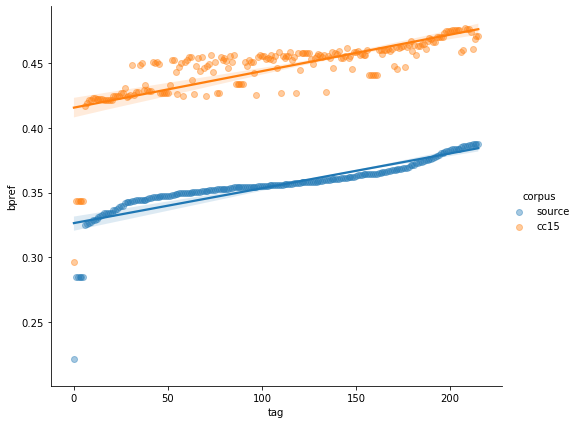

In [249]:
tmp_ss = query_dfs['cc15']
#tmp_ss = tmp_ss[np.logical_not(tmp_ss['tag'].str.contains('2'))]

regression_by_measure(build_topic_df(tmp_ss, topic_start=1, topic_end=300), 'bpref')

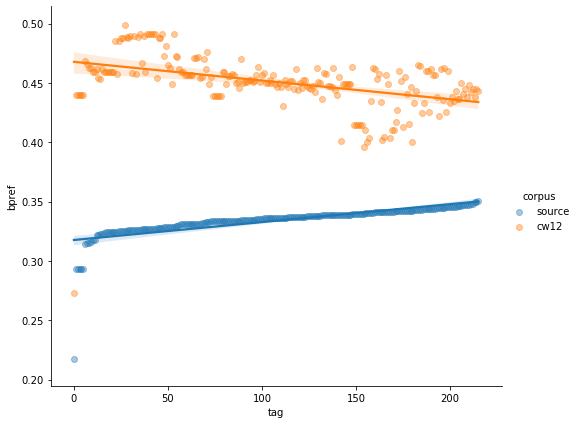

In [244]:
tmp_ss = query_dfs['cw12']
#tmp_ss = tmp_ss[np.logical_not(tmp_ss['tag'].str.contains('2'))]

regression_by_measure(build_topic_df(tmp_ss, topic_start=1, topic_end=20), 'bpref')

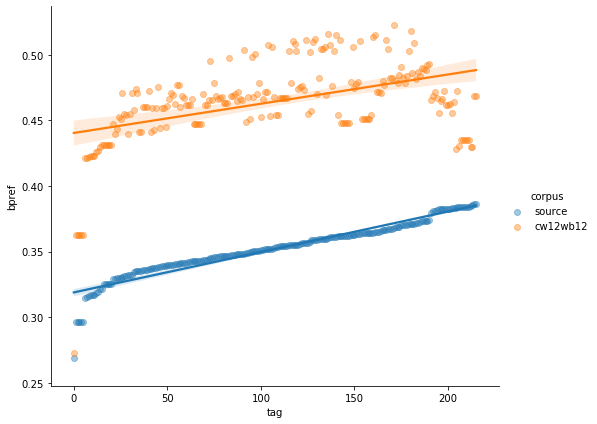

In [248]:
tmp_ss = query_dfs['cw12wb12']
#tmp_ss = tmp_ss[np.logical_not(tmp_ss['tag'].str.contains('2'))]

regression_by_measure(build_topic_df(tmp_ss, topic_start=25, topic_end=50), 'bpref')

In [ ]:
query_dfs

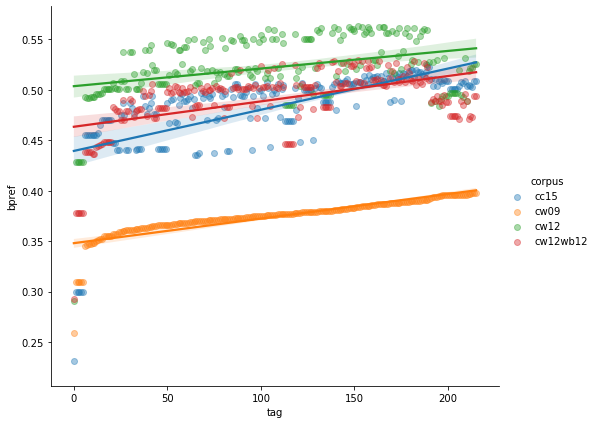

In [209]:
regression_by_measure(build_topic_df(query_df, topic_start=1, topic_end=50), 'bpref')

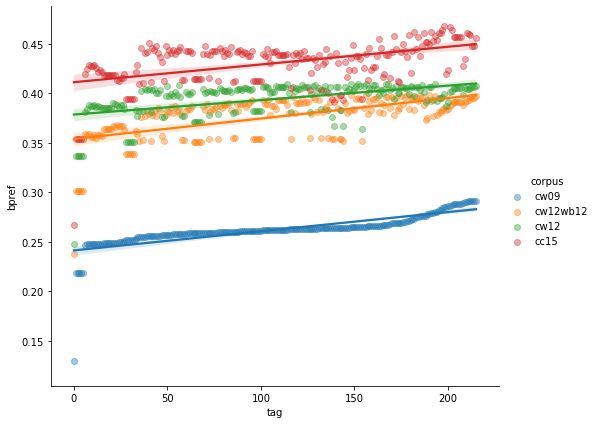

In [5]:
regression_by_measure(build_topic_df(query_df, topic_start=51, topic_end=100), 'bpref')

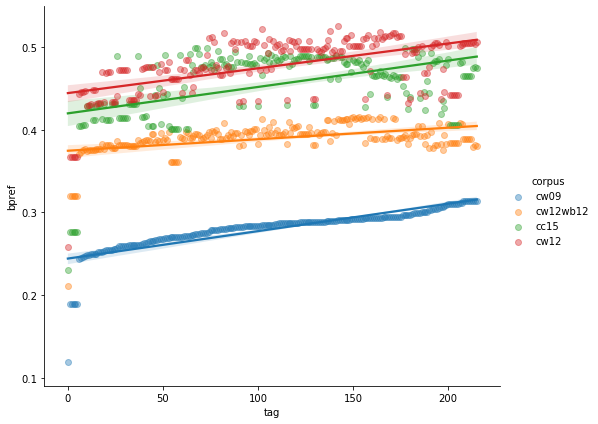

In [6]:
regression_by_measure(build_topic_df(query_df, topic_start=101, topic_end=150), 'bpref')

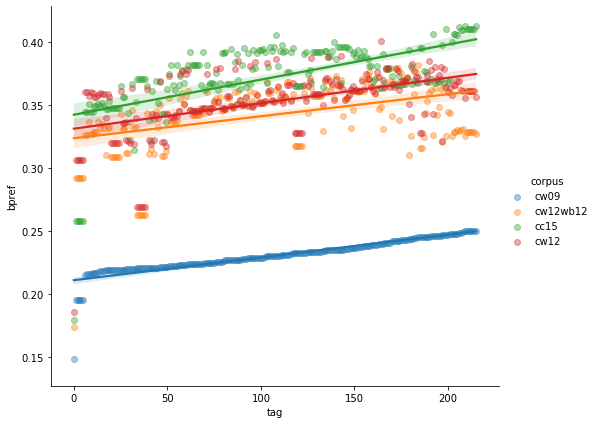

In [7]:
regression_by_measure(build_topic_df(query_df, topic_start=151, topic_end=200), 'bpref')

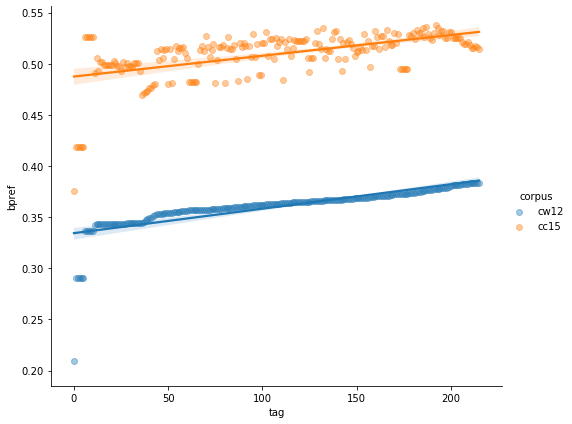

In [8]:
regression_by_measure(build_topic_df(query_df, topic_start=201, topic_end=250), 'bpref')

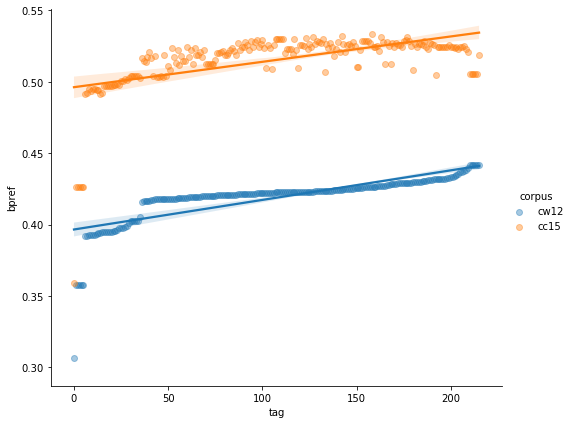

In [9]:
regression_by_measure(build_topic_df(query_df, topic_start=251, topic_end=300), 'bpref')

In [10]:
tmp_bla = build_topic_df(query_df, topic_start=1, topic_end=200)
tmp_bla["tag"] = tmp_bla["tag"] + tmp_bla["topics"]

# Unterschied micro vs macro avg
tmp_bla.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                               pseudoNDCG@10  \
corpus                      cc15      cw09      cw12  cw12wb12          cc15   
              corpus                                                           
bpref         cc15      1.000000  0.549851  0.537468  0.424510      0.655976   
              cw09      0.549851  1.000000  0.401802  0.408716      0.649439   
              cw12      0.537468  0.401802  1.000000  0.751897      0.376051   
              cw12wb12  0.424510  0.408716  0.751897  1.000000      0.376584   
pseudoNDCG@10 cc15      0.655976  0.649439  0.376051  0.376584      1.000000   
              cw09      0.603491  0.640145  0.450143  0.303743      0.559624   
              cw12      0.597293  0.467419  0.776746  0.663478      0.452839   
              cw12wb12  0.497856  0.400345  0.773564  0.707655      0.359338   

                                                      
corpus                      cw09      cw12  cw12wb12  
              corpus                                  
bpref         cc15      0.603491  0.597293  0.497856  
              cw09      0.640145  0.467419  0.400345  
              cw12      0.450143  0.776746  0.773564  
              cw12wb12  0.303743  0.663478  0.707655  
pseudoNDCG@10 cc15      0.559624  0.452839  0.359338  
              cw09      1.000000  0.476794  0.437348  
              cw12      0.476794  1.000000  0.743369  
              cw12wb12  0.437348  0.743369  1.000000

In [184]:
build_topic_df(query_dfs['cw12'], topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cw12    source          cw12    source
              corpus                                            
bpref         cw12    1.000000  0.455439      0.792192  0.467836
              source  0.455439  1.000000      0.482684  0.594682
pseudoNDCG@10 cw12    0.792192  0.482684      1.000000  0.471592
              source  0.467836  0.594682      0.471592  1.000000

In [190]:
build_topic_df(query_dfs['cw12'], topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cw12    source          cw12    source
              corpus                                            
bpref         cw12    1.000000  0.455439      0.792192  0.467836
              source  0.455439  1.000000      0.482684  0.594682
pseudoNDCG@10 cw12    0.792192  0.482684      1.000000  0.471592
              source  0.467836  0.594682      0.471592  1.000000

In [191]:
build_topic_df(query_dfs['cw12wb12'], topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                  cw12wb12    source      cw12wb12    source
              corpus                                              
bpref         cw12wb12  1.000000  0.442917      0.693012  0.281946
              source    0.442917  1.000000      0.413796  0.620691
pseudoNDCG@10 cw12wb12  0.693012  0.413796      1.000000  0.392167
              source    0.281946  0.620691      0.392167  1.000000

In [192]:
build_topic_df(query_dfs['cc15'], topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cc15    source          cc15    source
              corpus                                            
bpref         cc15    1.000000  0.716444      0.757516  0.549991
              source  0.716444  1.000000      0.614161  0.415451
pseudoNDCG@10 cc15    0.757516  0.614161      1.000000  0.626603
              source  0.549991  0.415451      0.626603  1.000000

In [11]:
tmp_bla = topic_df.copy()
tmp_bla["tag"] = tmp_bla["tag"] + tmp_bla["topics"]

tmp_bla.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                               pseudoNDCG@10  \
corpus                      cc15      cw09      cw12  cw12wb12          cc15   
              corpus                                                           
bpref         cc15      1.000000  0.286133  0.396907  0.570299      0.752012   
              cw09      0.286133  1.000000  0.608307  0.501077      0.404017   
              cw12      0.396907  0.608307  1.000000  0.775941      0.407711   
              cw12wb12  0.570299  0.501077  0.775941  1.000000      0.735963   
pseudoNDCG@10 cc15      0.752012  0.404017  0.407711  0.735963      1.000000   
              cw09      0.219985  0.808979  0.531894  0.407364      0.329751   
              cw12     -0.352666  0.357592  0.061234  0.357557     -0.189307   
              cw12wb12  0.151887  0.413939  0.322598  0.393426      0.367422   

                                                      
corpus                      cw09      cw12  cw12wb12  
              corpus                                  
bpref         cc15      0.219985 -0.352666  0.151887  
              cw09      0.808979  0.357592  0.413939  
              cw12      0.531894  0.061234  0.322598  
              cw12wb12  0.407364  0.357557  0.393426  
pseudoNDCG@10 cc15      0.329751 -0.189307  0.367422  
              cw09      1.000000  0.330548  0.399981  
              cw12      0.330548  1.000000  0.812782  
              cw12wb12  0.399981  0.812782  1.000000

In [12]:
tmp_bla = topic_df.copy()
tmp_bla = tmp_bla[tmp_bla['topics'].isin(['topics-201-250', 'topics-251-300'])]
tmp_bla["tag"] = tmp_bla["tag"] + tmp_bla["topics"]

tmp_bla.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cc15      cw12          cc15      cw12
              corpus                                            
bpref         cc15    1.000000  0.715353      0.263949  0.044819
              cw12    0.715353  1.000000      0.245440  0.111694
pseudoNDCG@10 cc15    0.263949  0.245440      1.000000  0.444601
              cw12    0.044819  0.111694      0.444601  1.000000

In [13]:
tmp_bla = topic_df.copy()
tmp_bla = tmp_bla[tmp_bla['topics'].isin(['topics-1-50', 'topics-51-100', 'topics-101-150', 'topics-151-200'])]
tmp_bla["tag"] = tmp_bla["tag"] + tmp_bla["topics"]

tmp_bla.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                               pseudoNDCG@10  \
corpus                      cc15      cw09      cw12  cw12wb12          cc15   
              corpus                                                           
bpref         cc15      1.000000  0.286133  0.488125  0.570299      0.645588   
              cw09      0.286133  1.000000  0.608307  0.501077      0.404017   
              cw12      0.488125  0.608307  1.000000  0.775941      0.619193   
              cw12wb12  0.570299  0.501077  0.775941  1.000000      0.735963   
pseudoNDCG@10 cc15      0.645588  0.404017  0.619193  0.735963      1.000000   
              cw09      0.219985  0.808979  0.531894  0.407364      0.329751   
              cw12      0.133133  0.357592  0.279846  0.357557      0.390272   
              cw12wb12  0.151887  0.413939  0.322598  0.393426      0.367422   

                                                      
corpus                      cw09      cw12  cw12wb12  
              corpus                                  
bpref         cc15      0.219985  0.133133  0.151887  
              cw09      0.808979  0.357592  0.413939  
              cw12      0.531894  0.279846  0.322598  
              cw12wb12  0.407364  0.357557  0.393426  
pseudoNDCG@10 cc15      0.329751  0.390272  0.367422  
              cw09      1.000000  0.330548  0.399981  
              cw12      0.330548  1.000000  0.812782  
              cw12wb12  0.399981  0.812782  1.000000

In [145]:
#tmp.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")
build_topic_df(tmp, topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cc15    source          cc15    source
              corpus                                            
bpref         cc15    1.000000  0.674653      0.773351  0.546360
              source  0.674653  1.000000      0.636644  0.502079
pseudoNDCG@10 cc15    0.773351  0.636644      1.000000  0.645089
              source  0.546360  0.502079      0.645089  1.000000

In [149]:
tmp

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topic,bpref,pseudoNDCG@10,tag,is_source_collection
35371,source,1.0,1.0,1.0,source,70,0.120000,0.177722,1.01.01.0,True
142634,webis_warc_commoncrawl15_002,1.0,1.0,1.0,cc15,3,0.000000,0.500000,1.01.01.0,False
140183,source,1.0,1.0,1.0,source,300,0.110285,0.167613,1.01.01.0,True
140182,source,1.0,1.0,1.0,source,299,0.700047,0.569437,1.01.01.0,True
140181,source,1.0,1.0,1.0,source,298,0.812124,0.545794,1.01.01.0,True
...,...,...,...,...,...,...,...,...,...,...
134340,source,0.0,0.0,0.0,source,257,0.474882,0.527048,0.00.00.0,True
134339,source,0.0,0.0,0.0,source,256,0.172781,0.271018,0.00.00.0,True
134338,source,0.0,0.0,0.0,source,255,0.250000,0.477038,0.00.00.0,True
134337,source,0.0,0.0,0.0,source,254,0.501125,0.255560,0.00.00.0,True


In [153]:
sss_tmp = tmp.copy()
sss_tmp['keep'] = sss_tmp.apply(lambda i: is_shallow_topic('cc15', i['topic']), axis=1)
sss_tmp = sss_tmp[sss_tmp['keep'] == True]

In [166]:
build_topic_df(sss_tmp, topic_start=1, topic_end=50).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cc15    source          cc15    source
              corpus                                            
bpref         cc15    1.000000  0.802325      0.803261  0.512024
              source  0.802325  1.000000      0.822129  0.586971
pseudoNDCG@10 cc15    0.803261  0.822129      1.000000  0.564158
              source  0.512024  0.586971      0.564158  1.000000

In [147]:
build_topic_df(tmp, topic_start=1, topic_end=300).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref           pseudoNDCG@10          
corpus                    cc15    source          cc15    source
              corpus                                            
bpref         cc15    1.000000  0.735823      0.394895  0.255448
              source  0.735823  1.000000      0.512877  0.416738
pseudoNDCG@10 cc15    0.394895  0.512877      1.000000  0.619102
              source  0.255448  0.416738      0.619102  1.000000

In [138]:
sssss = build_topic_df(tmp, topic_start=1, topic_end=300)
sssss[sssss['tag'] == '1.01.01.0']

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topics,bpref,pseudoNDCG@10,tag
647,webis_warc_commoncrawl15_002,1.0,1.0,1.0,cc15,topics-1-300,0.481450,0.673663,1.01.01.0
431,webis_warc_clueweb12_011,1.0,1.0,1.0,source,topics-1-300,0.393599,0.392323,1.01.01.0
215,webis_warc_clueweb09_003,1.0,1.0,1.0,source,topics-1-300,0.290459,0.274736,1.01.01.0


In [14]:
def extract_correlation(corr, measure, target):
    for k,v in corr.iterrows():
        if k == (measure, 'source'):
            try:
                ret = v[measure][target]
                if ret != ret:
                    return -100
                else:
                    return ret
            except:
                return -100
    return -100

def correlation_per_topic(query_df, topic: int, target_corpus):
    query_df = query_df[query_df['topic'].astype(int) == topic].copy()
    query_df["bpref"] = query_df["bpref"].fillna(0)
    query_df["pseudoNDCG@10"] = query_df["pseudoNDCG@10"].fillna(0)
    corr = query_df.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")
    
    return extract_correlation(corr, measure='bpref', target=target_corpus)

In [8]:
def load_topic_criteria():
    ret = {'cw12': {}, 'cw12wb12': {}, 'cc15': {}}
    
    with open('/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/data-19-10-2020/topic-selection-features.jsonl', 'r') as f:
        for jsonline in f:
            parsed_json = json.loads(jsonline)
            tmp_count = parsed_json['labelCount']
            if parsed_json['possibleLabelPermutations'] <= 3:
                tmp_count = 1
            
            ret[parsed_json['targetCorpus']][parsed_json['topic']] = {
                'labelCount': parsed_json['labelCount'],
                'possibleLabelPermutations': parsed_json['possibleLabelPermutations'],
                'tmp_count': tmp_count
            }
        
        return ret

In [9]:
def bla_tmp(measure, key):
    target_collection = measure.split('-to-')[1]
    query_df = query_dfs[target_collection]
    topics = [i for i in query_df.topic.unique()]
    topics = [i for i in topics if is_shallow_topic(target_collection, i)]
    
    topics = sorted(topics, key=key, reverse=False)
    ret = {}
    for i in range(1,len(topics)+1):
        selected_topics = [j for j in topics[len(topics)-i:]]
        tmp_df = build_topic_df(query_df, topics=selected_topics)
        corr = tmp_df.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")
        corr = extract_correlation(corr, measure.split('-to-')[0], target_collection)
        ret[i] = corr
        print(str(len(selected_topics)) + '-->' + str(corr))
    
    return ret


In [16]:
tmp_df = []

for target_corpus in ['cw12', 'cw12wb12', 'cc15']:
    query_df = query_dfs[target_corpus]
    for topic in query_df.topic.unique():
        corr = correlation_per_topic(query_df, topic, target_corpus)
        
        if corr >= -50:
            tmp_df += [{
                'corpus': target_corpus,
                'topic': topic,
                'correlation': corr
            }]

tmp_df = pd.DataFrame(tmp_df)

In [ ]:
tmp_df

In [18]:
tmp_for_plotting = {}
tmp_for_plotting2 = {}
tmp_for_plotting3 = {}
tmp_for_plotting4 = {}



topic_criteria = load_topic_criteria()

for _, r in tmp_df.iterrows():
    topic_criteria[r['corpus']][r['topic']]['correlation'] = r['correlation']

def tmp_topic_selection_criteria(topic, measure, key):
    corpus = measure.split('-to-')[1]
    measure = measure.split('-to-')[0]
    
    if topic in topic_criteria[corpus] and key in topic_criteria[corpus][topic]:
        return topic_criteria[corpus][topic][key]
    else:
        print('Could not handle topic ' + str(topic) + ' for ' + measure + ' @ ' + corpus)
        return -1

for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'bpref-to-cc15']:
    tmp_for_plotting[measure]= bla_tmp(measure, lambda i: tmp_topic_selection_criteria(i, measure, 'correlation'))
    tmp_for_plotting2[measure]= bla_tmp(measure, lambda i: tmp_topic_selection_criteria(i, measure, 'possibleLabelPermutations'))
    tmp_for_plotting3[measure]= bla_tmp(measure, lambda i: tmp_topic_selection_criteria(i, measure, 'labelCount'))
    tmp_for_plotting4[measure]= bla_tmp(measure, lambda i: tmp_topic_selection_criteria(i, measure, 'tmp_count'))

Could not handle topic 195 for bpref @ cw12
Could not handle topic 126 for bpref @ cw12
Could not handle topic 129 for bpref @ cw12
Could not handle topic 134 for bpref @ cw12
Could not handle topic 135 for bpref @ cw12
Could not handle topic 142 for bpref @ cw12
Could not handle topic 175 for bpref @ cw12
Could not handle topic 180 for bpref @ cw12
Could not handle topic 181 for bpref @ cw12
Could not handle topic 156 for bpref @ cw12
Could not handle topic 157 for bpref @ cw12
Could not handle topic 160 for bpref @ cw12
Could not handle topic 170 for bpref @ cw12
Could not handle topic 69 for bpref @ cw12
Could not handle topic 77 for bpref @ cw12
Could not handle topic 93 for bpref @ cw12
Could not handle topic 56 for bpref @ cw12
Could not handle topic 122 for bpref @ cw12
Could not handle topic 103 for bpref @ cw12
Could not handle topic 6 for bpref @ cw12
Could not handle topic 2 for bpref @ cw12
Could not handle topic 138 for bpref @ cw12
1-->1.0
2-->1.0
3-->0.727561068488126
4-

140-->0.7319746845518855
141-->0.7373113584192386
142-->0.7399578172347453
143-->0.739115312281594
144-->0.7241372100711214
145-->0.6769170705073173
146-->0.6813674553509762
147-->0.6786995889473884
148-->0.663375386248251
149-->0.6578787094018281
150-->0.658415628715618
151-->0.6327076619182949
152-->0.613972509718844
153-->0.6152306801866522
154-->0.6342673163940133
155-->0.6330897709537061
156-->0.6342163649481887
157-->0.6360591567565632
158-->0.5702292400713385
159-->0.5713167188526463
160-->0.49943448803127455
161-->0.5074815156219236
162-->0.4537427706263902
1-->0.002147624285880735
2-->-0.04000614126643434
3-->-0.1346191749971714
4-->0.06656930565534909
5-->-0.016872670394598357
6-->0.34958605697674316
7-->0.510865312806628
8-->0.6379467978579826
9-->0.6768145294607986
10-->0.6866848592402599
11-->0.6450699970728333
12-->0.686434597481861
13-->0.640106243065126
14-->0.6261108355519187
15-->0.623650301384036
16-->0.599564649542882
17-->0.6467170137181663
18-->0.6936091468255607


153-->0.476702197536213
154-->0.47919793241274955
155-->0.510069169558524
156-->0.5122683377335356
157-->0.4832057087761828
158-->0.49641102666468784
159-->0.5012507351937919
160-->0.5071341574312863
161-->0.5074815156219236
162-->0.4537427706263902
Could not handle topic 66 for bpref @ cw12wb12
Could not handle topic 77 for bpref @ cw12wb12
Could not handle topic 52 for bpref @ cw12wb12
Could not handle topic 170 for bpref @ cw12wb12
Could not handle topic 160 for bpref @ cw12wb12
Could not handle topic 152 for bpref @ cw12wb12
Could not handle topic 93 for bpref @ cw12wb12
Could not handle topic 195 for bpref @ cw12wb12
Could not handle topic 188 for bpref @ cw12wb12
Could not handle topic 175 for bpref @ cw12wb12
Could not handle topic 180 for bpref @ cw12wb12
Could not handle topic 200 for bpref @ cw12wb12
Could not handle topic 122 for bpref @ cw12wb12
Could not handle topic 107 for bpref @ cw12wb12
Could not handle topic 142 for bpref @ cw12wb12
Could not handle topic 135 for bpr

104-->0.6843559017691131
105-->0.6863120377409712
106-->0.6864016008352184
107-->0.6891706763679303
108-->0.7191734640091649
109-->0.7003632107819894
110-->0.6682470664694962
111-->0.6540962585418785
112-->0.6758578800135943
113-->0.6717265115934554
114-->0.6767859098886359
115-->0.7037665274878218
116-->0.7061714461542604
117-->0.6985452491390275
118-->0.7008480342948048
119-->0.7223225171321308
120-->0.7163672802493881
121-->0.7192936680428957
122-->0.7132045929018789
123-->0.7628906351185916
124-->0.7689029033023891
125-->0.7536420989583972
126-->0.7480431443025625
127-->0.7616707618508112
128-->0.7632631769262292
129-->0.7764225007276311
130-->0.7765140852686332
131-->0.7739102078141751
132-->0.7679262541542337
133-->0.775175594751861
134-->0.7812697191391961
135-->0.7842446654508844
136-->0.782557660404647
137-->0.7811242813186747
138-->0.7833858883692634
139-->0.7903092634073241
140-->0.7818672708813155
141-->0.8054546688482462
142-->0.8065056208555605
143-->0.8113502943092796
14

85-->0.5963713893566664
86-->0.5827785953280669
87-->0.5790916346870011
88-->0.5834693234584388
89-->0.5766946156109304
90-->0.5711115114754927
91-->0.564721764223166
92-->0.5616378939082768
93-->0.4582318138691479
94-->0.4588780372172957
95-->0.46324857249053053
96-->0.4633387720576676
97-->0.4538195427631472
98-->0.46337910008111033
99-->0.4610665232228286
100-->0.46133096016458064
101-->0.4735777249817817
102-->0.452725928288263
103-->0.45687555087256493
104-->0.45409850502585775
105-->0.44523737379503425
106-->0.4346407362511159
107-->0.4362243824982048
108-->0.4366500602441472
109-->0.4433808459390024
110-->0.44338556314970146
111-->0.44273814157524843
112-->0.4520059181025982
113-->0.47705027228600755
114-->0.4676658092625925
115-->0.48726371261212825
116-->0.4602432267823668
117-->0.4738868494300835
118-->0.48488144855035986
119-->0.47934389085417856
120-->0.4797041621475968
121-->0.47276683992155477
122-->0.47205725876923443
123-->0.4723080287621086
124-->0.47234125873131727
12

73-->0.8180019033675519
74-->0.8111800123427562
75-->0.7996345675419334
76-->0.7964151465409485
77-->0.8012267323347539
78-->0.7937440451391868
79-->0.8046632104918767
80-->0.8084236549529622
81-->0.8200230695295532
82-->0.7915687817462149
83-->0.7884192912616813
84-->0.7882373442047225
85-->0.7850585222590225
86-->0.7937606064164134
87-->0.7941528356711306
88-->0.78570652283879
89-->0.8037322227988691
90-->0.8182708041865604
91-->0.8227771081025824
92-->0.8361579512104831
93-->0.8121573474469065
94-->0.8009225042297122
95-->0.8084939763440211
96-->0.8092772297814512
97-->0.8309191383830707
98-->0.8317167658123134
99-->0.832133303201055
100-->0.8352943737159015
101-->0.8379195597664202
102-->0.8324886395569704
103-->0.8284968583145914
104-->0.8279462304780962
105-->0.836649930314503
106-->0.8454662115665321
107-->0.8457205052733078
108-->0.8518293149698758
109-->0.8594735705327998
110-->0.8562166868120045
111-->0.8558131515596212
112-->0.8451267785142398
113-->0.8504262384297078
114-->

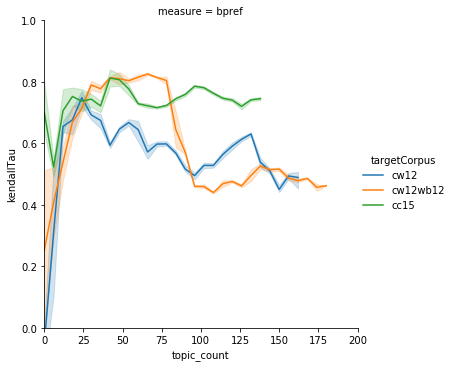

In [26]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'bpref-to-cc15']:
        if topic_count in tmp_for_plotting3[measure]:
            bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                     'measure': measure.split('-to-')[0],
                     'targetCorpus': measure.split('-to-')[1],
                     'kendallTau': tmp_for_plotting3[measure][topic_count]
                }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))
plt_bla.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-case-study-count-based-selection.pdf', format='pdf')

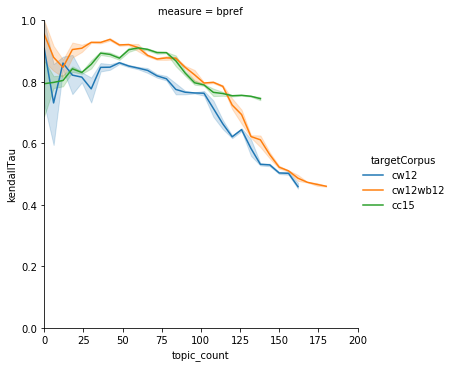

In [27]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'bpref-to-cc15']:
        if topic_count in tmp_for_plotting4[measure]:
            bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                     'measure': measure.split('-to-')[0],
                     'targetCorpus': measure.split('-to-')[1],
                     'kendallTau': tmp_for_plotting[measure][topic_count]
                }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))
plt_bla.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-case-study-best-case-selection.pdf', format='pdf')

In [33]:
tmp_for_plotting = {}

for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'bpref-to-cc15']:
    tmp_for_plotting[measure]= bla_tmp(query_df, measure, lambda i: i[measure])

1-->0.9249310224218645
2-->0.8356054530874097
3-->0.863010002753507
4-->0.9495703515977382
5-->0.746176601864479
6-->0.5364420930084423
7-->0.6455193750406624
8-->0.8466188821623954
9-->0.8076325814068068
10-->0.8967886984119847
11-->0.9198170753601891
12-->0.8739561244642823
13-->0.8943292905919178
14-->0.9260960533495401
15-->0.9367290606400415
16-->0.8688337230486336
17-->0.8658917906828579
18-->0.8777341959427662
19-->0.878569583116106
20-->0.9014278968885292
21-->0.9013434711403416
22-->0.8716190640103351
23-->0.8229002712636153
24-->0.8254707841007622
25-->0.8177975514369747
26-->0.8118717915534275
27-->0.8068245666038308
28-->0.8011383302624531
29-->0.8538657745764732
30-->0.8626690196729875
31-->0.8748922260490926
32-->0.8556894376953343
33-->0.7958616232045914
34-->0.8038628184058114
35-->0.8144139984509481
36-->0.8162455928919896
37-->0.8101954163167937
38-->0.7776076815064137
39-->0.7645042451721402
40-->0.7583500486102639
41-->0.7836509558633428
42-->0.7982669890190834
43--

139-->0.5407910366570308
140-->0.5349709193894843
141-->0.5270529483125919
142-->0.5254401656285522
143-->0.5279782909382237
144-->0.5342613342527152
145-->0.5400676604186062
146-->0.5454819742882772
147-->0.5460619912820666
148-->0.5321666446123182
149-->0.5339510839732458
150-->0.5330977422637129
151-->0.5257078845543156
152-->0.5183620694470515
153-->0.5206353322232616
154-->0.5149150788861109
155-->0.47860853172446016
156-->0.4739881919253174
157-->0.46708470802448615
158-->0.4675184772000277
159-->0.4549078789470403
160-->0.4574667686048043
161-->0.45779549713163425
162-->0.46655749182095946
163-->0.46833451947795635
164-->0.46833451860809683
165-->0.468030084370474
166-->0.4677614003137745
167-->0.46408482672802864
168-->0.46385931683964216
169-->0.4639886216111083
170-->0.46374000571102103
171-->0.47311596243988335
172-->0.47121953420462503
173-->0.47106743487606806
174-->0.4690974933383309
175-->0.4749612153481243
176-->0.4738362068965517
177-->0.47246708177511904
178-->0.47879

In [17]:
tmp_df.sort_values('correlation')

,corpus,topic,correlation
317,cc15,286,-0.632211
280,cw12wb12,16,-0.553171
357,cc15,78,-0.455845
367,cc15,119,-0.454820
376,cc15,69,-0.440692
...,...,...,...
240,cw12wb12,148,0.933114
72,cw12,92,1.000000
278,cw12wb12,13,1.000000
201,cw12wb12,92,1.000000


In [23]:
tmp_df.sort_values('correlation')

,corpus,correlation
313,cc15,-0.683041
392,cc15,-0.581193
185,cw12wb12,-0.538300
365,cc15,-0.449632
407,cc15,-0.449035
...,...,...
182,cw12wb12,0.913232
4,cw12,0.913232
283,cw12wb12,0.924931
124,cw12,0.924931


In [28]:
tmp_df[tmp_df['correlation'] >= 0.8].groupby('corpus').agg({
    'correlation': 'count'
})

,correlation
corpus,
cc15,3
cw12,9
cw12wb12,15


In [30]:
tmp_df[tmp_df['correlation'] >= 0.9].groupby('corpus').agg({
    'correlation': 'count'
})

,correlation
corpus,
cw12,2
cw12wb12,3


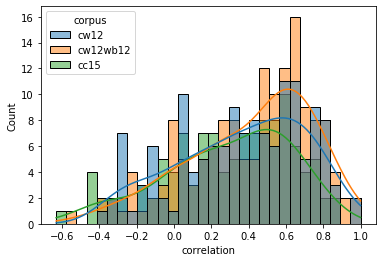

In [31]:
f = sns.histplot(data=tmp_df, x='correlation', hue='corpus', bins=30, kde=True)
f.figure.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-case-study-topic-level-correlation.pdf', format='pdf')

In [39]:
print('Best-Strategy for CW12@50 topics: ' + '{:.2f}'.format(tmp_for_plotting['bpref-to-cw12'][50]))
print('Best-Strategy for CW12WB12@50 topics: ' + '{:.2f}'.format(tmp_for_plotting['bpref-to-cw12wb12'][50]))
print('Best-Strategy for CC15 topics: ' + '{:.2f}'.format(tmp_for_plotting['bpref-to-cc15'][50]))

Best-Strategy for CW12@50 topics: 0.86
Best-Strategy for CW12WB12@50 topics: 0.92
Best-Strategy for CC15 topics: 0.87


In [40]:
print('Count-Based-Strategy for CW12@50 topics: ' + '{:.2f}'.format(tmp_for_plotting3['bpref-to-cw12'][50]))
print('Count-Based-Strategy for CW12WB12@50 topics: ' + '{:.2f}'.format(tmp_for_plotting3['bpref-to-cw12wb12'][50]))
print('Count-Based-Strategy for CC15 topics: ' + '{:.2f}'.format(tmp_for_plotting3['bpref-to-cc15'][50]))

Count-Based-Strategy for CW12@50 topics: 0.66
Count-Based-Strategy for CW12WB12@50 topics: 0.80
Count-Based-Strategy for CC15 topics: 0.80
